# Data Preparation

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from google.colab import drive


### Data Exploration on tumor_091 at level 5

In [30]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0   222M      0  0:00:02  0:00:02 --:--:--  222M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  81.0M      0 --:--:-- --:--:-- --:--:-- 81.0M


In [31]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [32]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

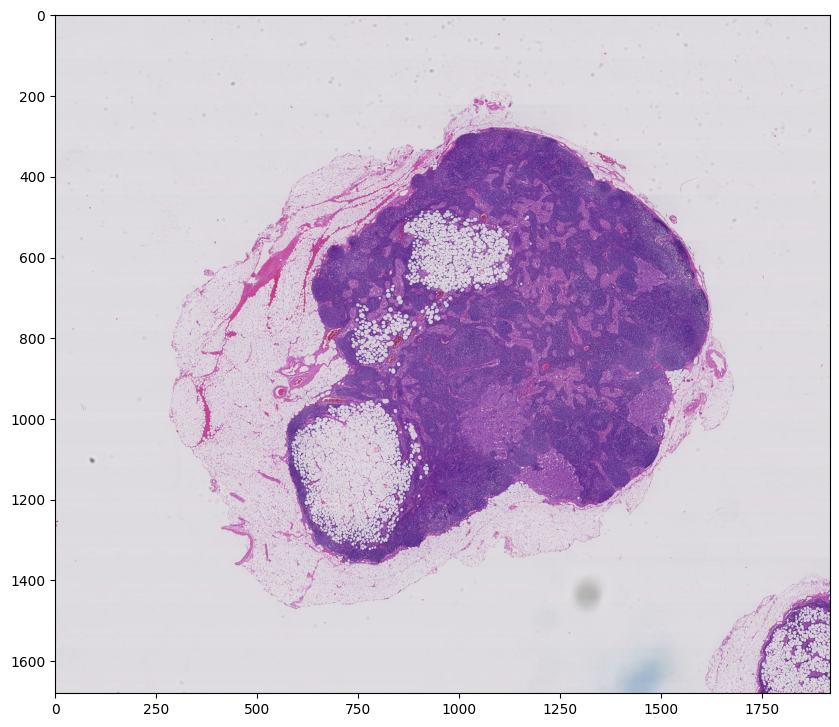

In [33]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

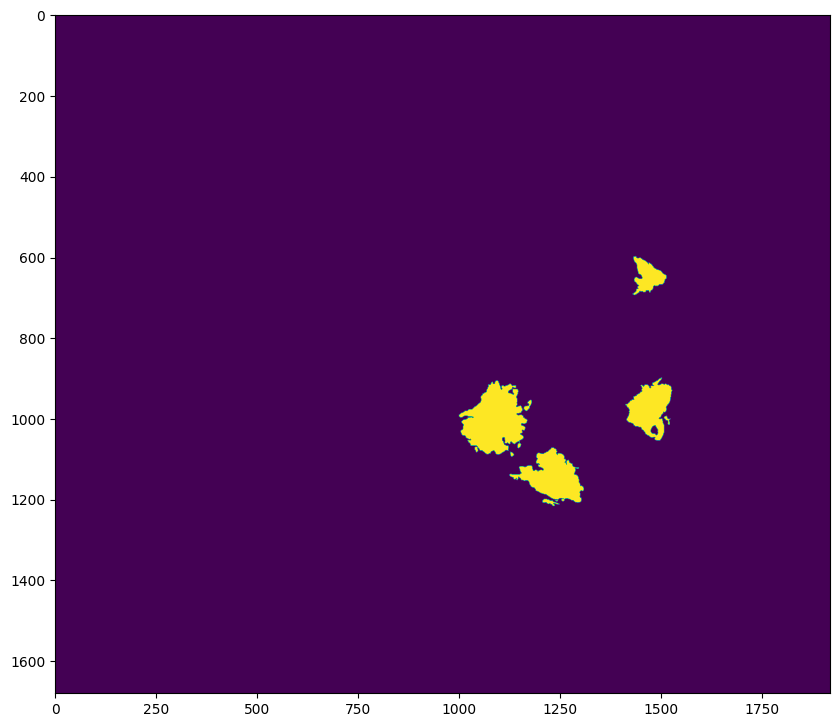

In [34]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

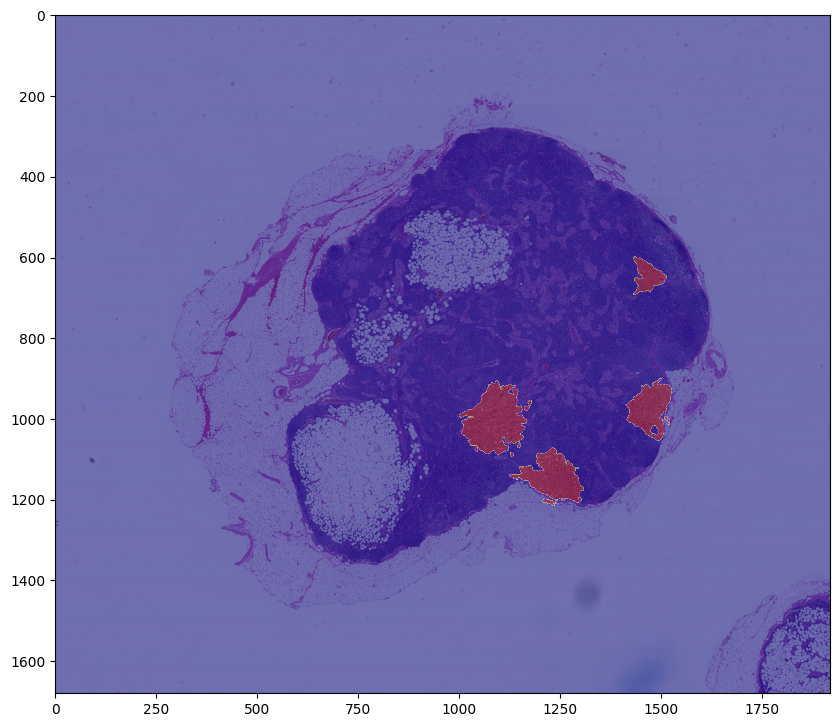

In [35]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

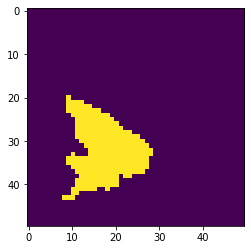

In [36]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=130 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

905504 tissue_pixels pixels (28.1 percent of the image)


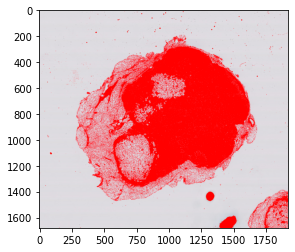

In [37]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

## Save Slices to Disk

In [4]:
import os
import pandas as pd

In [5]:
drive.mount('/content/gdrive/')
drive_root_dir = '/content/gdrive/My Drive/'
slides_directory_path = drive_root_dir+'slides/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [154]:
from generate_slices import Slide2Slice

In [155]:
!ls '$slides_directory_path'

 tumor_001_mask.tif   tumor_031.xml	   tumor_081.tif
 tumor_001.tif	      tumor_035_mask.tif   tumor_081.xml
 tumor_001.xml	      tumor_035.tif	   tumor_084_mask.tif
 tumor_002_mask.tif   tumor_035.xml	   tumor_084.tif
 tumor_002.tif	     'tumor_038 (1).xml'   tumor_084.xml
 tumor_002.xml	      tumor_038.tif	   tumor_091_mask.tif
 tumor_005_mask.tif   tumor_038.xml	   tumor_091.tif
 tumor_005.tif	      tumor_057_mask.tif   tumor_091.xml
 tumor_005.xml	      tumor_057.tif	   tumor_094_mask.tif
 tumor_012_mask.tif   tumor_057.xml	   tumor_094.tif
 tumor_012.tif	      tumor_059_mask.tif   tumor_094.xml
 tumor_012.xml	      tumor_059.tif	   tumor_096_mask.tif
 tumor_016_mask.tif   tumor_059.xml	   tumor_096.tif
 tumor_016.tif	      tumor_064_mask.tif   tumor_096.xml
 tumor_016.xml	      tumor_064.tif	   tumor_099.xml
 tumor_019_mask.tif   tumor_064.xml	   tumor_101_mask.tif
 tumor_019.tif	      tumor_075_mask.tif   tumor_101.tif
 tumor_019.xml	      tumor_075.tif	   tumor_101.xml
 tumor_02

In [24]:
all_data_slides=[ 'tumor_001', 'tumor_002', 'tumor_005', 
                   'tumor_012', 'tumor_016', 'tumor_019', 
                   'tumor_023', 'tumor_031', 'tumor_035', 
                   'tumor_057', 'tumor_059', 'tumor_064',
                   'tumor_075', 'tumor_078', 'tumor_081', 
                   'tumor_084', 'tumor_091', 'tumor_094', 
                   'tumor_096', 'tumor_101', 'tumor_110',]

train_data_slides = all_data_slides[:18] # 18 Training Slides
test_data_slides = all_data_slides[18:] # 3 Testing Slides

In [157]:
train_sliced_slides_dir = drive_root_dir + 'slices_train/'

stats_df = pd.DataFrame()
for level in [4,5]:
  level_df = Slide2Slice(train_data_slides,slides_directory_path, sliced_slides_dir=train_sliced_slides_dir, level=level,slice_size=229).run()
  stats_df = stats_df.append(level_df, ignore_index=True)

Reset level 4 directory
slicing tumor_001 on level 4 and size 229
{'slide_name': 'tumor_001', 'level': 4, 'negative': 1556, 'positive': 4, 'negative_with_tissue': 287, 'positive_with_tissue': 4}
slicing tumor_002 on level 4 and size 229
{'slide_name': 'tumor_002', 'level': 4, 'negative': 1532, 'positive': 2, 'negative_with_tissue': 117, 'positive_with_tissue': 2}
slicing tumor_005 on level 4 and size 229
{'slide_name': 'tumor_005', 'level': 4, 'negative': 1530, 'positive': 4, 'negative_with_tissue': 135, 'positive_with_tissue': 4}
slicing tumor_012 on level 4 and size 229
{'slide_name': 'tumor_012', 'level': 4, 'negative': 1504, 'positive': 4, 'negative_with_tissue': 139, 'positive_with_tissue': 2}
slicing tumor_016 on level 4 and size 229
{'slide_name': 'tumor_016', 'level': 4, 'negative': 1530, 'positive': 30, 'negative_with_tissue': 100, 'positive_with_tissue': 29}
slicing tumor_019 on level 4 and size 229
{'slide_name': 'tumor_019', 'level': 4, 'negative': 1532, 'positive': 2, 'neg

In [158]:
stats_df

,slide_name,level,negative,positive,negative_with_tissue,positive_with_tissue
0,tumor_001,4,1556,4,287,4
1,tumor_002,4,1532,2,117,2
2,tumor_005,4,1530,4,135,4
3,tumor_012,4,1504,4,139,2
4,tumor_016,4,1530,30,100,29
5,tumor_019,4,1532,2,93,2
6,tumor_023,4,1553,7,152,7
7,tumor_031,4,1524,36,52,33
8,tumor_035,4,1558,2,157,2
9,tumor_057,4,1556,4,137,4


In [159]:
test_sliced_slides_dir = drive_root_dir + 'slices_test/'

test_stats_df = pd.DataFrame()
for level in [4,5]:
  level_df = Slide2Slice(test_data_slides,slides_directory_path, sliced_slides_dir=test_sliced_slides_dir, level=level,slice_size=229).run()
  test_stats_df = test_stats_df.append(level_df, ignore_index=True)


Reset level 4 directory
slicing tumor_096 on level 4 and size 229
{'slide_name': 'tumor_096', 'level': 4, 'negative': 643, 'positive': 22, 'negative_with_tissue': 255, 'positive_with_tissue': 20}
slicing tumor_101 on level 4 and size 229
{'slide_name': 'tumor_101', 'level': 4, 'negative': 672, 'positive': 50, 'negative_with_tissue': 221, 'positive_with_tissue': 46}
slicing tumor_110 on level 4 and size 229
{'slide_name': 'tumor_110', 'level': 4, 'negative': 348, 'positive': 127, 'negative_with_tissue': 113, 'positive_with_tissue': 122}
Reset level 5 directory
slicing tumor_096 on level 5 and size 229
{'slide_name': 'tumor_096', 'level': 5, 'negative': 143, 'positive': 10, 'negative_with_tissue': 67, 'positive_with_tissue': 9}
slicing tumor_101 on level 5 and size 229
{'slide_name': 'tumor_101', 'level': 5, 'negative': 145, 'positive': 26, 'negative_with_tissue': 56, 'positive_with_tissue': 22}
slicing tumor_110 on level 5 and size 229
{'slide_name': 'tumor_110', 'level': 5, 'negative':

In [160]:
test_stats_df

,slide_name,level,negative,positive,negative_with_tissue,positive_with_tissue
0,tumor_096,4,643,22,255,20
1,tumor_101,4,672,50,221,46
2,tumor_110,4,348,127,113,122
3,tumor_096,5,143,10,67,9
4,tumor_101,5,145,26,56,22
5,tumor_110,5,63,45,23,42


# Model Training

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load Data

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_sliced_slides_dir = drive_root_dir + 'slices_train/'

print('\nLoading level 4 train and val data')
train_level4_path = train_sliced_slides_dir + 'level4/'
lvl4_train_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_level4_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(229,229), 
                shuffle=True, seed=1, validation_split=0.2, subset='training')


lvl4_val_data = tf.keras.preprocessing.image_dataset_from_directory( 
                train_level4_path, labels='inferred', label_mode='binary',
                class_names=['0negative','1positive'], image_size=(229,229), 
                shuffle=True, seed=1, validation_split=0.2, subset='validation')
class_names = lvl4_train_data.class_names

lvl4_train_data = lvl4_train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
lvl4_val_data = lvl4_val_data.cache().prefetch(buffer_size=AUTOTUNE)


Loading level 4 train and val data
Found 3244 files belonging to 2 classes.
Using 2596 files for training.
Found 3244 files belonging to 2 classes.
Using 648 files for validation.


In [9]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

## Models

### Baseline

In [68]:
IMG_SIZE = 229
num_classes = 2

baseline_model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(48, activation='relu'),
  layers.Dense(num_classes)
])

baseline_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_194 (Conv2D)          (None, 229, 229, 16)      448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 114, 114, 16)      0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 207936)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 48)                9980976   
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 98        
Total params: 9,981,522
Trainable params: 9,981,522
Non-trainable params: 0
_________________________________________________________________


In [76]:
baseline_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [77]:
epochs=10
history = baseline_model.fit(
  lvl4_train_data,
  validation_data=lvl4_val_data,
  epochs=epochs
)

Epoch 1/10
82/82 [==============================] - 2s 22ms/step - loss: 7.1248 - accuracy: 0.9314 - val_loss: 8.1887 - val_accuracy: 0.8796
Epoch 2/10
82/82 [==============================] - 2s 19ms/step - loss: 0.1366 - accuracy: 0.9838 - val_loss: 5.9007 - val_accuracy: 0.8904
Epoch 3/10
82/82 [==============================] - 2s 19ms/step - loss: 0.0540 - accuracy: 0.9919 - val_loss: 4.5253 - val_accuracy: 0.8719
Epoch 4/10
82/82 [==============================] - 2s 19ms/step - loss: 0.0570 - accuracy: 0.9927 - val_loss: 5.9387 - val_accuracy: 0.8812
Epoch 5/10
82/82 [==============================] - 2s 19ms/step - loss: 0.0100 - accuracy: 0.9988 - val_loss: 6.4261 - val_accuracy: 0.8750
Epoch 6/10
82/82 [==============================] - 2s 19ms/step - loss: 0.0077 - accuracy: 0.9988 - val_loss: 6.8008 - val_accuracy: 0.8765
Epoch 7/10
82/82 [==============================] - 2s 19ms/step - loss: 0.0068 - accuracy: 0.9988 - val_loss: 7.3605 - val_accuracy: 0.8750
Epoch 8/10
82

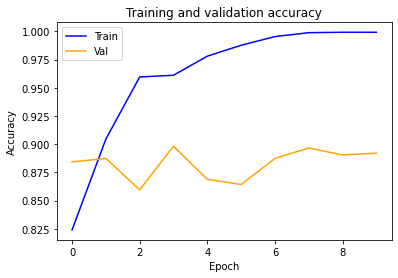

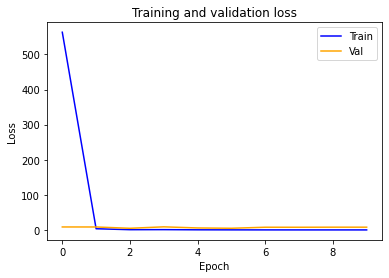

In [71]:
plot(history)

### Transfer Learning with Inception V3

In [58]:
tl_base = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',input_shape=(229,229,3))

fine_tune_model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(48, activation='relu'),
  layers.Dense(num_classes)
])

model_input = tl_base.input
model_output = fine_tune_model(tl_base.output)

tl_inception_model = tf.keras.Model(model_input,model_output)


In [59]:
tl_inception_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [60]:
epochs=10
history = tl_inception_model.fit(
  lvl4_train_data,
  validation_data=lvl4_val_data,
  epochs=epochs
)

Epoch 1/10
82/82 [==============================] - 22s 274ms/step - loss: 0.3969 - accuracy: 0.8817 - val_loss: 1930.5579 - val_accuracy: 0.8827
Epoch 2/10
82/82 [==============================] - 20s 246ms/step - loss: 0.3182 - accuracy: 0.8821 - val_loss: 0.3366 - val_accuracy: 0.8827
Epoch 3/10
82/82 [==============================] - 21s 252ms/step - loss: 0.2789 - accuracy: 0.8867 - val_loss: 0.3745 - val_accuracy: 0.8827
Epoch 4/10
82/82 [==============================] - 21s 255ms/step - loss: 0.2653 - accuracy: 0.9029 - val_loss: 1.3480 - val_accuracy: 0.8503
Epoch 5/10
82/82 [==============================] - 21s 257ms/step - loss: 0.2638 - accuracy: 0.8918 - val_loss: 0.5298 - val_accuracy: 0.8812
Epoch 6/10
82/82 [==============================] - 21s 255ms/step - loss: 0.2479 - accuracy: 0.8998 - val_loss: 0.3268 - val_accuracy: 0.9213
Epoch 7/10
82/82 [==============================] - 21s 255ms/step - loss: 0.2392 - accuracy: 0.9072 - val_loss: 0.3515 - val_accuracy: 0.8

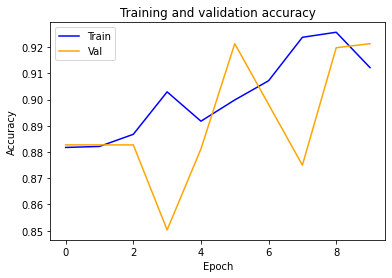

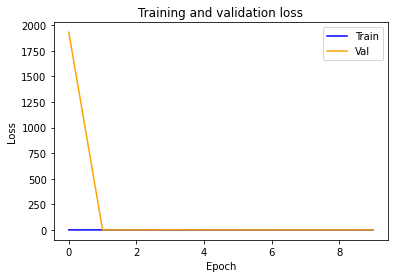

In [61]:
plot(history)

# Heatmap on Test Images

In [25]:
test_data_slides

['tumor_096', 'tumor_101', 'tumor_110']

In [26]:
from evaluation import heatmap_on_test

### Baseline model evaluation

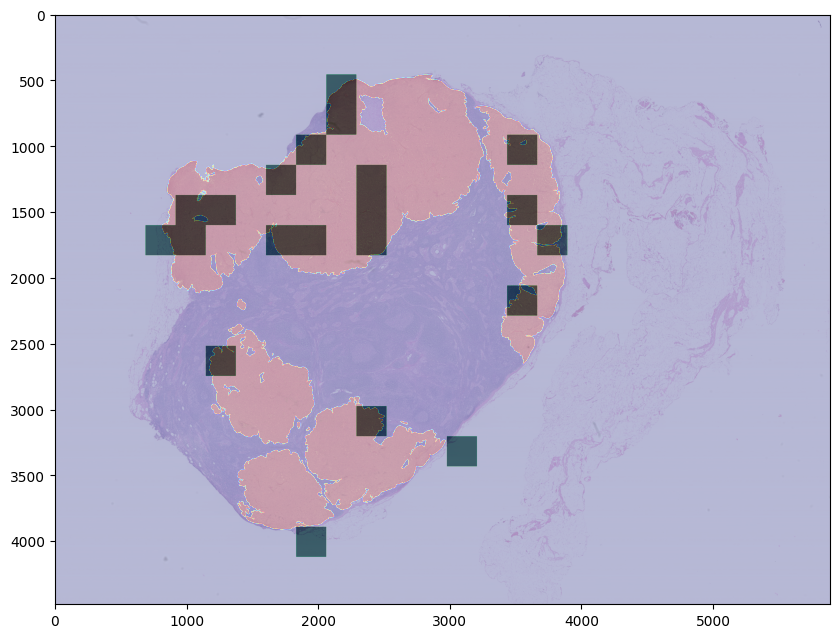

In [78]:
cnf_matrix = heatmap_on_test(4,test_data_slides[2],229,baseline_model).generate()

In [79]:
pd.DataFrame(cnf_matrix.numpy(), columns=['Pred Negative','Pred Positive'], index=['Actual Negative','Actual Positive'])

,Pred Negative,Pred Positive
Actual Negative,347,1
Actual Positive,107,20


### Transfer Learning with Inception V3

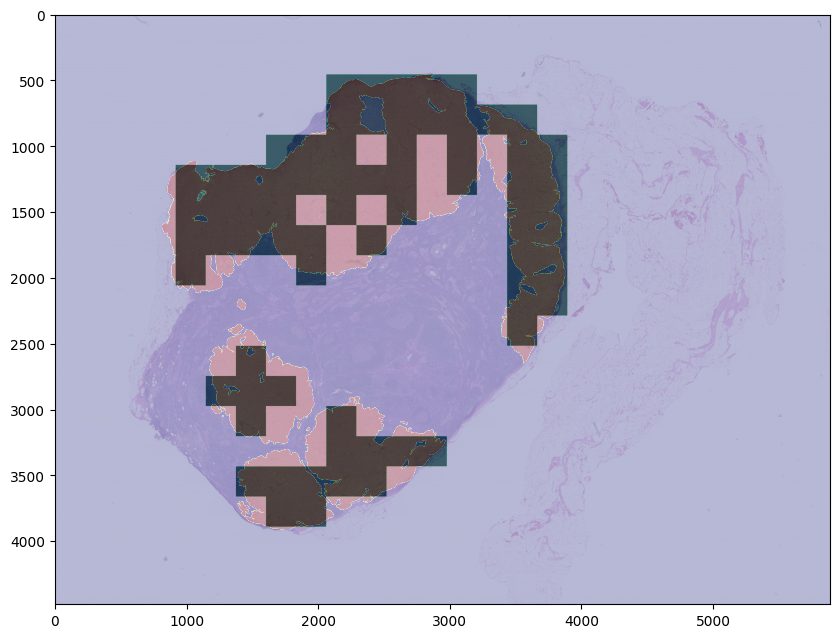

In [80]:
cnf_matrix = heatmap_on_test(4,test_data_slides[2],229,tl_inception_model).generate()

In [81]:
pd.DataFrame(cnf_matrix.numpy(), columns=['Pred Negative','Pred Positive'], index=['Actual Negative','Actual Positive'])

,Pred Negative,Pred Positive
Actual Negative,348,0
Actual Positive,57,70
